In [1]:
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

from segmentation_pipeline.data_processing.subject_filters import ComposeFilters, RequireAttributes
from segmentation_pipeline.data_processing.subject_folder import SubjectFolder

from segmentation_pipeline.data_processing.subject_loaders import (
    AttributeLoader,
    ComposeLoaders,
    ImageLoader,
)

In [2]:
subject_loader = ComposeLoaders(
    [
        ImageLoader(
            glob_pattern="whole_roi.*",
            image_name="whole_roi",
            image_constructor=tio.LabelMap,
            label_values={"left_whole": 1, "right_whole": 2},
        ),
        AttributeLoader(glob_pattern="attributes.*"),
        AttributeLoader(
            glob_pattern="../../attributes/cross_validation_split.json", multi_subject=True, uniform=True
        ),
        AttributeLoader(
            glob_pattern="../../attributes/ab300_validation_subjects.json", multi_subject=True, uniform=True
        ),
        AttributeLoader(
            glob_pattern="../../attributes/cbbrain_test_subjects.json", multi_subject=True, uniform=True
        ),
    ]
)

input_images = ["mean_dwi", "md", "fa"]

cohorts = {}
cohorts['all'] = RequireAttributes(['whole_roi'])
cohorts['cross_validation'] = RequireAttributes(['fold'])


all_subjects = SubjectFolder(root="/Volumes/Extra Files/Diffusion_MRI", subject_path="subjects", subject_loader=subject_loader, cohorts=cohorts)

subjects = all_subjects.get_cohort_dataset("cross_validation")


In [3]:
spatial_dims = (1, 2, 3)
left_volumes = np.stack([(subject['whole_roi']['data'] == 1).sum(dim=spatial_dims) for subject in subjects]).reshape(-1)
right_volumes = np.stack([(subject['whole_roi']['data'] == 2).sum(dim=spatial_dims) for subject in subjects]).reshape(-1)
total_volumes = np.stack([(subject['whole_roi']['data'] != 0).sum(dim=spatial_dims) for subject in subjects]).reshape(-1)

age = np.stack([subject['age'] for subject in subjects]).reshape(-1)

In [4]:
((right_volumes + left_volumes) == total_volumes).all() # quick test

True

In [5]:

params = {
    'left': {"vol": left_volumes, 'param': np.polyfit(age, left_volumes, 2)}, 
    'right': {"vol": right_volumes, 'param': np.polyfit(age, right_volumes, 2)}, 
    'total': {'vol': total_volumes, 'param': np.polyfit(age, total_volumes, 2)}
}

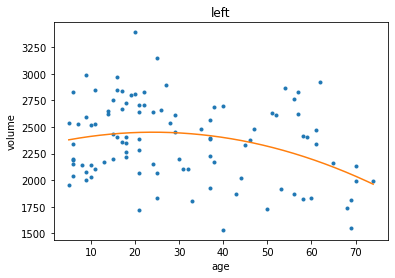

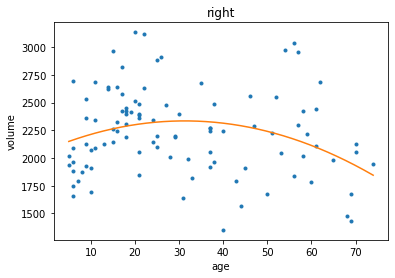

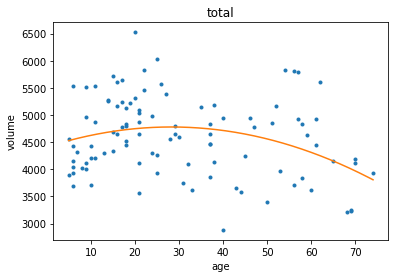

In [6]:
for location, data in params.items():
    poly_func = np.poly1d(data['param'])
    age_curve = np.linspace(age.min(), age.max(), 1000)
    plt.plot(age, data['vol'], '.', age_curve, poly_func(age_curve), "-")
    plt.title(location)
    plt.xlabel("age"),
    plt.ylabel("volume")
    plt.show()

In [7]:
params['left']['param']

array([-1.96312119e-01,  9.46668029e+00,  2.33635173e+03])

In [8]:
params['right']['param']

array([-2.68467331e-01,  1.67925603e+01,  2.07224236e+03])